# Tweet sentiment analysis during Covid times

### API set-up

In [76]:
# Import libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
plt.style.use('fivethirtyeight')

In [2]:
# Twitter API credentials
consumer_key = 'wrrHhdKxgYfKH0WKwOm7Uyylq'
consumer_secret = '9qb3hTNywK5lU5YTIYSxd3ADrloD9xhjdlQJzRwXL4wk3Up4Ar'
access_token = '284537952-dKg8gIk3Chn85c6jB0OLsbMdv7dqOtgKBc5iRONK'
access_token_secret = '6cv20z56cCwUbopvN8PHKqo2bcQIzHD0pShpZxnHDnadH'

In [3]:
# Create authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
public_tweets = api.home_timeline()

In [4]:
# search_words = "#wildfires"

columns=['text', 'user', 'date', 'source', 'location', 'url']
msgs = []
msg =[]

for tweet in tweepy.Cursor(api.search, lang='en', q='#skincare', rpp=100).items(5000):
    msg = [tweet.text, tweet.user.screen_name, tweet.created_at, tweet.source, tweet.user.location, tweet.source_url] 
    msg = tuple(msg)                    
    msgs.append(msg)

    
df = pd.DataFrame(msgs, columns=columns)

### Language processing

In [5]:
def remove_by_regex(tweet, regexp):
        return re.sub(regexp, '', tweet)

def remove_url(tweet):
    return remove_by_regex(tweet, re.compile(r"http.?://[^\s]+[\s]?"))

def remove_special_char(tweet):
    return re.sub(r"[^a-zA-Z0-9 ]", " ", tweet) #add space placeholder

def remove_numbers(tweet):
    return remove_by_regex(tweet, re.compile(r"[1234567890]"))

def clean_up(tweet):
    tweet = remove_numbers(tweet)
    tweet = remove_url(tweet)
    tweet = remove_special_char(tweet)
    return tweet.lower().strip()

In [6]:
df['clean_text'] = df['text'].apply(clean_up)

In [7]:
tt = TweetTokenizer()
df['tokenized'] = df['clean_text'].apply(tt.tokenize)

In [8]:
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    return [x for x in text if x not in stopwords_list]

In [9]:
df['text_processed'] = df['tokenized'].apply(remove_stopwords)

In [10]:
def stem_list(l):
    stemmer = SnowballStemmer("english")
    stemmed = []
    for i in l:
        stemmed.append(stemmer.stem(i))
    return stemmed

In [11]:
df['text_stemmed'] = df['text_processed'].apply(stem_list)

In [12]:
def stem_lem(l):
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for i in l:
        lemmatized.append(lemmatizer.lemmatize(i))
    return lemmatized

In [13]:
df['text_lemmatized'] = df['text_stemmed'].apply(stem_lem)

In [14]:
def sentiment(l):
    sid = SentimentIntensityAnalyzer()
    sentiments = []
    sentiments.append(sid.polarity_scores(l))
    return sentiments

In [15]:
df['sentiment'] = df['clean_text'].apply(lambda x: sentiment(x))

In [16]:
c = list(df.iloc[0]['sentiment'][0].keys())
c

['neg', 'neu', 'pos', 'compound']

In [17]:
s = pd.DataFrame([list(df["sentiment"].apply(lambda x: x[0].values()).loc[i]) for i in range(df.shape[0])], columns = c)

In [18]:
df_s = pd.concat([df,s], axis = 1)

In [21]:
df_s['pos'].median()

0.1885

In [22]:
df_s['neg'].median()

0.0

In [23]:
df_s

text            user  \
0     🌿Regenerating Arctic Oat Extract adds an extra...   greenglaze_ke   
1     RT @libertysoap: Rosemary Soap, Hand Crafted S...  atticesoterica   
2     RT @libertysoap: Unscented Soap, Sensitive Ski...  atticesoterica   
3     RT @libertysoap: Shaving Soap With Natural Hai...  atticesoterica   
4     RT @libertysoap: Almond Biscotti Soap, Hand-Cr...  atticesoterica   
...                                                 ...             ...   
4995  RT @libertysoap: Adult Washable Reusable Cloth...     AmiAmiGocco   
4996  Full-spectrum CBD, what is it? And how any wom...    DiscoverSelf   
4997  RT @libertysoap: Adult Washable Reusable Cloth...  MegMusicManiac   
4998  REVIEW of one of my top treatments! @SurreyLif...  LisaHarrisSkin   
4999  RT @Skin_On_: Our products are not for women o...     canvasgirl_   

                    date              source           location  \
0    2020-12-14 10:51:00  Twitter for iPhone     Nairobi, Kenya   
1    2020-12-14 10:46:29     Twitter Web App       Abington, PA   
2    2020-12-14 10:46:23     Twitter Web App       Abington, PA   
3    2020-12-14 10:46:18     Twitter Web App       Abington, PA   
4    2020-12-14 10:46:11     Twitter Web App       Abington, PA   
...                  ...                 ...                ...   
4995 2020-12-10 16:11:49  Twitter for iPhone  Staten Island, NY   
4996 2020-12-10 16:09:10            Sendible                USA   
4997 2020-12-10 16:09:05     Twitter Web App         California   
4998 2020-12-10 16:07:54  Twitter for iPhone  Weybridge, Surrey   
4999 2020-12-10 16:07:40  Twitter for iPhone     Dream cottage    

                                     url  \
0     http://twitter.com/download/iphone   
1             https://mobile.twitter.com   
2             https://mobile.twitter.com   
3             https://mobile.twitter.com   
4             https://mobile.twitter.com   
...                                  ...   
4995  http://twitter.com/download/iphone   
4996            https://app.sendible.com   
4997          https://mobile.twitter.com   
4998  http://twitter.com/download/iphone   
4999  http://twitter.com/download/iphone   

                                             clean_text  \
0     regenerating arctic oat extract adds an extra ...   
1     rt  libertysoap  rosemary soap  hand crafted s...   
2     rt  libertysoap  unscented soap  sensitive ski...   
3     rt  libertysoap  shaving soap with natural hai...   
4     rt  libertysoap  almond biscotti soap  hand cr...   
...                                                 ...   
4995  rt  libertysoap  adult washable reusable cloth...   
4996  full spectrum cbd  what is it  and how any wom...   
4997  rt  libertysoap  adult washable reusable cloth...   
4998  review of one of my top treatments   surreylif...   
4999  rt  skin on   our products are not for women o...   

                                              tokenized  \
0     [regenerating, arctic, oat, extract, adds, an,...   
1     [rt, libertysoap, rosemary, soap, hand, crafte...   
2     [rt, libertysoap, unscented, soap, sensitive, ...   
3     [rt, libertysoap, shaving, soap, with, natural...   
4     [rt, libertysoap, almond, biscotti, soap, hand...   
...                                                 ...   
4995  [rt, libertysoap, adult, washable, reusable, c...   
4996  [full, spectrum, cbd, what, is, it, and, how, ...   
4997  [rt, libertysoap, adult, washable, reusable, c...   
4998  [review, of, one, of, my, top, treatments, sur...   
4999  [rt, skin, on, our, products, are, not, for, w...   

                                         text_processed  \
0     [regenerating, arctic, oat, extract, adds, ext...   
1     [rt, libertysoap, rosemary, soap, hand, crafte...   
2     [rt, libertysoap, unscented, soap, sensitive, ...   
3     [rt, libertysoap, shaving, soap, natural, hair...   
4     [rt, libertysoap, almond, biscotti, soap, hand...   
...                                         

### Create the bag of words

In [33]:
all_words = []

for index, value in df_s.text_lemmatized.iteritems():
    if value not in all_words:
        all_words += value

top_features = [x[0] for x in nltk.FreqDist(all_words).most_common(50)]

In [34]:
top_features

['skincar',
 'rt',
 'soap',
 'skin',
 'beauti',
 'product',
 'amp',
 'bodi',
 'get',
 'natur',
 'cream',
 'free',
 'gift',
 'face',
 'care',
 'bar',
 'make',
 'holiday',
 'libertysoap',
 'shave',
 'oil',
 'elidaskincar',
 'look',
 'makeup',
 'new',
 'hair',
 'vegan',
 'butter',
 'love',
 'vitamin',
 'organ',
 'buy',
 'special',
 'christma',
 'bump',
 'best',
 'help',
 'day',
 'shop',
 'skincareroutin',
 'sale',
 'hey',
 'incred',
 'mask',
 'naturalskincar',
 'moistur',
 'win',
 'includ',
 'acid',
 'cold']

In [54]:
negative_tweets = df_s[df_s['neg'] > df_s['pos']]
positive_tweets = df_s[df_s['neg'] < df_s['pos']]

Build a dataframe with the most repeated words for both positive and negative tweets.

In [55]:
all_words_pos = []

for index, value in positive_tweets.text_lemmatized.iteritems():
    if value not in all_words:
        all_words_pos += value

top_features_pos = [x[0] for x in nltk.FreqDist(all_words).most_common(50)]

In [56]:
all_words_neg = []

for index, value in negative_tweets.text_lemmatized.iteritems():
    if value not in all_words:
        all_words_neg += value

top_features_neg = [x[0] for x in nltk.FreqDist(all_words).most_common(50)]

In [57]:
def build_features(words):
    features = {}
    for w in top_features:
        features[w] = (1 if w in words else 0)
    return features

In [58]:
featuresets = []

for index, row in df_s.iterrows():
    featuresets.append((build_features(row['text_lemmatized'])))

In [59]:
featuresets_pos = []

for index, row in positive_tweets.iterrows():
    featuresets_pos.append((build_features(row['text_lemmatized'])))

In [60]:
featuresets_neg = []

for index, row in negative_tweets.iterrows():
    featuresets_neg.append((build_features(row['text_lemmatized'])))

In [61]:
featuresets

[{'skincar': 0,
  'rt': 0,
  'soap': 0,
  'skin': 0,
  'beauti': 0,
  'product': 0,
  'amp': 0,
  'bodi': 0,
  'get': 0,
  'natur': 0,
  'cream': 0,
  'free': 0,
  'gift': 0,
  'face': 0,
  'care': 0,
  'bar': 0,
  'make': 0,
  'holiday': 0,
  'libertysoap': 0,
  'shave': 0,
  'oil': 0,
  'elidaskincar': 0,
  'look': 0,
  'makeup': 0,
  'new': 0,
  'hair': 0,
  'vegan': 0,
  'butter': 0,
  'love': 0,
  'vitamin': 0,
  'organ': 0,
  'buy': 0,
  'special': 0,
  'christma': 0,
  'bump': 0,
  'best': 0,
  'help': 0,
  'day': 0,
  'shop': 0,
  'skincareroutin': 0,
  'sale': 0,
  'hey': 0,
  'incred': 0,
  'mask': 0,
  'naturalskincar': 0,
  'moistur': 0,
  'win': 0,
  'includ': 0,
  'acid': 0,
  'cold': 0},
 {'skincar': 0,
  'rt': 1,
  'soap': 1,
  'skin': 0,
  'beauti': 0,
  'product': 0,
  'amp': 0,
  'bodi': 0,
  'get': 0,
  'natur': 1,
  'cream': 0,
  'free': 0,
  'gift': 0,
  'face': 0,
  'care': 0,
  'bar': 0,
  'make': 0,
  'holiday': 0,
  'libertysoap': 1,
  'shave': 0,
  'oil': 1,


In [62]:
features = pd.DataFrame(featuresets)

In [63]:
features_pos = pd.DataFrame(featuresets_pos)

In [64]:
features_neg = pd.DataFrame(featuresets_neg)

In [65]:
features.sum().sort_values(ascending=False)

skincar           1955
rt                1628
skin              1233
product            801
beauti             750
amp                502
bodi               454
get                437
soap               427
natur              413
cream              400
face               310
care               301
bar                301
gift               299
free               281
make               280
libertysoap        275
holiday            258
look               248
oil                248
new                222
vegan              217
butter             213
makeup             212
hair               206
organ              205
buy                205
vitamin            201
special            197
love               196
christma           188
skincareroutin     175
help               175
best               174
hey                169
incred             169
day                166
shop               166
sale               166
naturalskincar     165
includ             158
acid               157
moistur    

In [66]:
features_pos.sum().sort_values(ascending=False)

skincar           1260
rt                1188
skin               851
beauti             746
product            643
bodi               417
natur              404
amp                395
soap               388
cream              376
get                359
care               298
bar                290
free               277
gift               262
holiday            258
face               224
libertysoap        223
vegan              207
special            197
butter             196
vitamin            195
love               195
organ              195
oil                193
makeup             183
make               176
buy                174
best               173
help               165
skincareroutin     163
incred             162
acid               153
naturalskincar     151
cold               146
win                146
christma           143
includ             141
new                139
sale               136
elidaskincar       134
hey                134
look               130
shop       

In [79]:
neg_words = features_neg.sum().sort_values(ascending=False)

In [68]:
features

skincar  rt  soap  skin  beauti  product  amp  bodi  get  natur  ...  \
0           0   0     0     0       0        0    0     0    0      0  ...   
1           0   1     1     0       0        0    0     0    0      1  ...   
2           0   1     1     1       0        0    0     1    0      1  ...   
3           0   1     1     0       0        0    0     0    0      1  ...   
4           0   1     1     0       0        0    0     0    0      0  ...   
...       ...  ..   ...   ...     ...      ...  ...   ...  ...    ...  ...   
4995        0   1     0     0       0        0    0     0    0      0  ...   
4996        0   0     0     0       1        1    0     0    0      0  ...   
4997        0   1     0     0       0        0    0     0    0      0  ...   
4998        1   0     0     0       0        0    0     0    0      0  ...   
4999        0   1     0     1       0        1    0     0    0      0  ...   

      sale  hey  incred  mask  naturalskincar  moistur  win  includ  acid  \
0        0    0       0     0               0        0    0       0     0   
1        0    0       0     0               0        0    0       0     0   
2        0    0       0     0               0        0    0       0     0   
3        0    0       0     0               0        0    0       0     0   
4        0    0       0     0               0        0    0       0     0   
...    ...  ...     ...   ...             ...      ...  ...     ...   ...   
4995     0    0       0     1               0        0    0       0     0   
4996     0    0       0     0               0        0    1       0     0   
4997     0    0       0     1               0        0    0       0     0   
4998     0    0       0     0               0        0    0       0     0   
4999     0    0       0     0               0        0    0       0     0   

      cold  
0        0  
1        0  
2        1  
3        0  
4        1  
...    ...  
4995     0  
4996     0  
4997     0  
4998     0  
4999     0  

[5000 rows x 50 columns]

In [69]:
features.to_csv('./features.csv')

In [70]:
features.sum().sort_values(ascending=False).to_csv('./features2.csv')

In [85]:
feat_dict=dict(features.sum().sort_values(ascending=False))

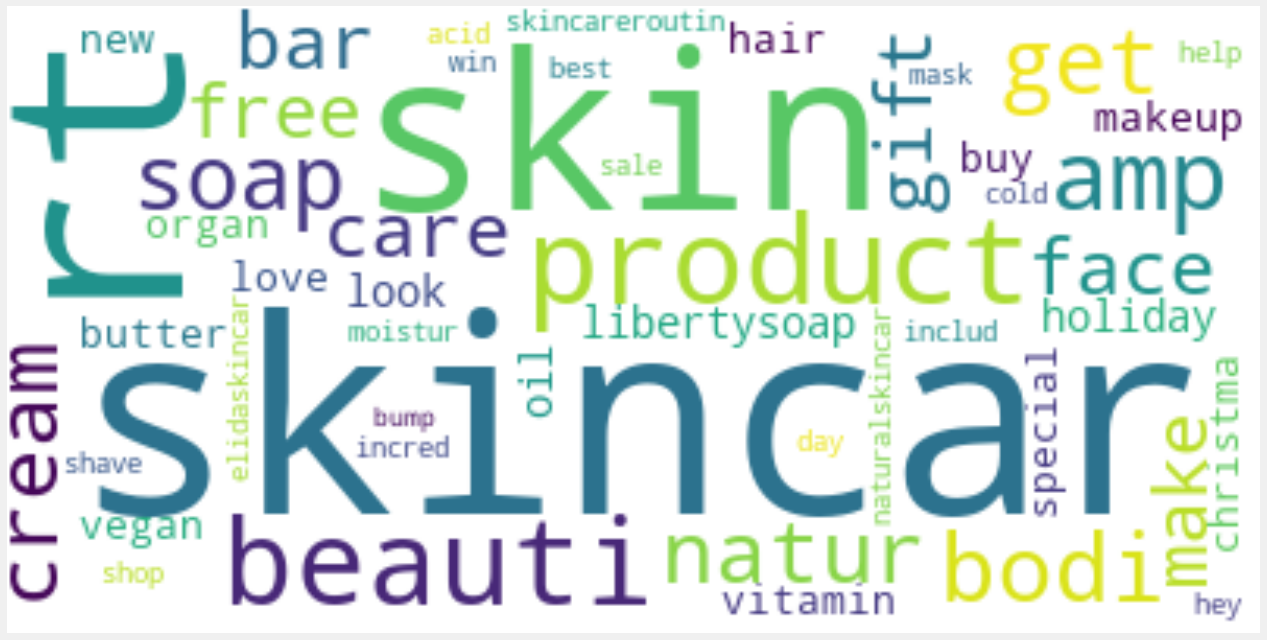

In [91]:
"""
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=feat_dict)
plt.figure(figsize=(20,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
"""

### Create a model to better predict the negativity score

In [95]:
features

skincar  rt  soap  skin  beauti  product  amp  bodi  get  natur  ...  \
0           0   0     0     0       0        0    0     0    0      0  ...   
1           0   1     1     0       0        0    0     0    0      1  ...   
2           0   1     1     1       0        0    0     1    0      1  ...   
3           0   1     1     0       0        0    0     0    0      1  ...   
4           0   1     1     0       0        0    0     0    0      0  ...   
...       ...  ..   ...   ...     ...      ...  ...   ...  ...    ...  ...   
4995        0   1     0     0       0        0    0     0    0      0  ...   
4996        0   0     0     0       1        1    0     0    0      0  ...   
4997        0   1     0     0       0        0    0     0    0      0  ...   
4998        1   0     0     0       0        0    0     0    0      0  ...   
4999        0   1     0     1       0        1    0     0    0      0  ...   

      hey  incred  mask  naturalskincar  moistur  win  includ  acid  cold  neg  
0       0       0     0               0        0    0       0     0     0  0.0  
1       0       0     0               0        0    0       0     0     0  0.0  
2       0       0     0               0        0    0       0     0     1  0.0  
3       0       0     0               0        0    0       0     0     0  0.0  
4       0       0     0               0        0    0       0     0     1  0.0  
...   ...     ...   ...             ...      ...  ...     ...   ...   ...  ...  
4995    0       0     1               0        0    0       0     0     0  0.0  
4996    0       0     0               0        0    1       0     0     0  0.0  
4997    0       0     1               0        0    0       0     0     0  0.0  
4998    0       0     0               0        0    0       0     0     0  0.0  
4999    0       0     0               0        0    0       0     0     0  0.0  

[5000 rows x 51 columns]

In [94]:
features['neg'] = df_s['neg']

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [102]:
X=features.drop(columns='neg')
y=features['neg']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

In [103]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [106]:
y_pred = linear_reg.predict(X_test)

In [107]:
from sklearn.metrics import r2_score
r2_score(y_pred, y_test)

-5.204183681807737

In [97]:
features_neg

skincar  rt  soap  skin  beauti  product  amp  bodi  get  natur  ...  \
0          1   0     0     0       0        0    0     0    0      0  ...   
1          1   1     0     1       0        0    0     0    0      0  ...   
2          1   0     0     0       0        1    0     0    0      0  ...   
3          1   0     0     0       0        1    0     0    0      0  ...   
4          1   1     0     1       0        0    0     0    0      0  ...   
..       ...  ..   ...   ...     ...      ...  ...   ...  ...    ...  ...   
497        0   1     0     1       0        0    0     0    0      0  ...   
498        0   1     0     0       0        0    0     0    0      0  ...   
499        0   0     0     1       0        0    0     0    0      0  ...   
500        1   0     0     0       0        0    0     0    0      0  ...   
501        1   0     0     1       0        0    0     0    0      0  ...   

     sale  hey  incred  mask  naturalskincar  moistur  win  includ  acid  cold  
0       0    0       0     0               0        0    0       0     0     0  
1       0    0       0     0               0        0    0       0     0     0  
2       0    0       0     0               0        0    0       0     0     0  
3       0    0       0     0               0        1    0       0     0     0  
4       0    0       0     0               0        0    0       0     0     0  
..    ...  ...     ...   ...             ...      ...  ...     ...   ...   ...  
497     0    0       0     0               0        0    0       0     0     0  
498     0    0       0     0               0        0    0       0     0     0  
499     0    0       0     0               0        0    0       0     0     0  
500     0    0       0     0               0        0    0       0     0     0  
501     0    0       0     0               0        0    0       0     0     0  

[502 rows x 50 columns]

In [108]:
from sklearn.ensemble import RandomForestRegressor

In [109]:
RFR = RandomForestRegressor()

In [110]:
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [111]:
y_pred = RFR.predict(X_test)

In [112]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_pred, y_test, squared=False)

### Evaluation of the models

In [113]:
rms

0.06445301927250173

In [114]:
from sklearn import svm

In [116]:
clf = svm.SVR()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rms = mean_squared_error(y_pred, y_test, squared=False)

In [117]:
rms

0.09775358868473015

In [118]:
from sklearn.tree import DecisionTreeRegressor

In [119]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
rms = mean_squared_error(y_pred, y_test, squared=False)
rms

0.06709858626642617